## Visualize Training Run 2b

- Was hoping to not have to train myself, but not super surprised that I need to. ]
- Starting here: https://colab.research.google.com/drive/1F6_1_cWXE5M7WocUcpQWp3v8z4b1jL20#scrollTo=Jpfq01sZyPdC
- Ok feels like some light frequency based regularization may actually work here - pretty dope!

In [1]:
seed=2

In [2]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm.notebook as tqdm

import random
import time

# from google.colab import drive
from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools

## Support Functions

In [3]:
# A helper class to get access to intermediate activations (inspired by Garcon)
# It's a dummy module that is the identity function by default
# I can wrap any intermediate activation in a HookPoint and get a convenient 
# way to add PyTorch hooks
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    
    def give_name(self, name):
        # Called by the model at initialisation
        self.name = name
    
    def add_hook(self, hook, dir='fwd'):
        # Hook format is fn(activation, hook_name)
        # Change it into PyTorch hook format (this includes input and output, 
        # which are the same for a HookPoint)
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    
    def forward(self, x):
        return x

In [4]:
# Define network architecture
# I defined my own transformer from scratch so I'd fully understand each component 
# - I expect this wasn't necessary or particularly important, and a bunch of this 
# replicates existing PyTorch functionality

# Embed & Unembed
class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# LayerNorm
class LayerNorm(nn.Module):
    def __init__(self, d_model, epsilon = 1e-4, model=[None]):
        super().__init__()
        self.model = model
        self.w_ln = nn.Parameter(torch.ones(d_model))
        self.b_ln = nn.Parameter(torch.zeros(d_model))
        self.epsilon = epsilon
    
    def forward(self, x):
        if self.model[0].use_ln:
            x = x - x.mean(axis=-1)[..., None]
            x = x / (x.std(axis=-1)[..., None] + self.epsilon)
            x = x * self.w_ln
            x = x + self.b_ln
            return x
        else:
            return x

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, model):
        super().__init__()
        self.model = model
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked = torch.tril(attn_scores_pre) - 1e10 * (1 - self.mask[:x.shape[-2], :x.shape[-2]])
        attn_matrix = self.hook_attn(F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

# MLP Layers
class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type, model):
        super().__init__()
        self.model = model
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_model))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        x = self.hook_post(x)
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model):
        super().__init__()
        self.model = model
        # self.ln1 = LayerNorm(d_model, model=self.model)
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, model=self.model)
        # self.ln2 = LayerNorm(d_model, model=self.model)
        self.mlp = MLP(d_model, d_mlp, act_type, model=self.model)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn((self.hook_resid_pre(x)))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp((x))))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_mlp, d_head, num_heads, n_ctx, act_type, use_cache=False, use_ln=True):
        super().__init__()
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_mlp, d_head, num_heads, n_ctx, act_type, model=[self]) for i in range(num_layers)])
        # self.ln = LayerNorm(d_model, model=[self])
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for block in self.blocks:
            x = block(x)
        # x = self.ln(x)
        x = self.unembed(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')

In [5]:
# Helper functions
def cuda_memory():
    print(torch.cuda.memory_allocated()/1e9)

def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss

def full_loss(model, data):
    # Take the final position only
    logits = model(data)[:, -1]
    labels = torch.tensor([fn(i, j) for i, j, _ in data]).to('cuda')
    return cross_entropy_high_precision(logits, labels)

def test_logits(logits, bias_correction=False, original_logits=None, mode='all'):
    # Calculates cross entropy loss of logits representing a batch of all p^2 
    # possible inputs
    # Batch dimension is assumed to be first
    if logits.shape[1]==p*p:
        logits = logits.T
    if logits.shape==torch.Size([p*p, p+1]):
        logits = logits[:, :-1]
    logits = logits.reshape(p*p, p)
    if bias_correction:
        # Applies bias correction - we correct for any missing bias terms, 
        # independent of the input, by centering the new logits along the batch 
        # dimension, and then adding the average original logits across all inputs
        logits = einops.reduce(original_logits - logits, 'batch ... -> ...', 'mean') + logits
    if mode=='train':
        return cross_entropy_high_precision(logits[is_train], labels[is_train])
    elif mode=='test':
        return cross_entropy_high_precision(logits[is_test], labels[is_test])
    elif mode=='all':
        return cross_entropy_high_precision(logits, labels)

def unflatten_first(tensor):
    if tensor.shape[0]==p*p:
        return einops.rearrange(tensor, '(x y) ... -> x y ...', x=p, y=p)
    else: 
        return tensor
def cos(x, y):
    return (x.dot(y))/x.norm()/y.norm()
def mod_div(a, b):
    return (a*pow(b, p-2, p))%p
def normalize(tensor, axis=0):
    return tensor/(tensor).pow(2).sum(keepdim=True, axis=axis).sqrt()
def extract_freq_2d(tensor, freq):
    # Takes in a pxpx... or batch x ... tensor, returns a 3x3x... tensor of the 
    # Linear and quadratic terms of frequency freq
    tensor = unflatten_first(tensor)
    # Extracts the linear and quadratic terms corresponding to frequency freq
    index_1d = [0, 2*freq-1, 2*freq]
    # Some dumb manipulation to use fancy array indexing rules
    # Gets the rows and columns in index_1d
    return tensor[[[i]*3 for i in index_1d], [index_1d]*3]
def get_cov(tensor, norm=True):
    # Calculate covariance matrix
    if norm:
        tensor = normalize(tensor, axis=1)
    return tensor @ tensor.T
def is_close(a, b):
    return ((a-b).pow(2).sum()/(a.pow(2).sum().sqrt())/(b.pow(2).sum().sqrt())).item()

In [6]:
def compute_frequency_components(m):
    """
    Compute canonical frequency components of a real 2D signal m using fft2.

    Returns:
        components: list of dicts with keys:
            - 'kx': frequency index in x (rows)
            - 'ky': frequency index in y (cols)
            - 'coeff': complex FFT coefficient at (kx, ky)
        Nx, Ny: dimensions of the input
    """
    m = np.asarray(m)
    Nx, Ny = m.shape
    F = np.fft.fft2(m)

    components = []
    seen = set()

    for kx in range(Nx):
        for ky in range(Ny):
            # Conjugate partner indices for real-valued input
            kx_conj = (-kx) % Nx
            ky_conj = (-ky) % Ny

            pair = tuple(sorted([(kx, ky), (kx_conj, ky_conj)]))
            if pair in seen:
                continue
            seen.add(pair)

            # Always store the "smaller" one in lexicographic order
            kx_rep, ky_rep = pair[0]
            coeff = F[kx_rep, ky_rep]
            components.append({
                "kx": kx_rep,
                "ky": ky_rep,
                "coeff": coeff
            })

    return components, Nx, Ny


def components_to_terms(components, Nx, Ny, num_freqs, include_dc=True):
    """
    Convert FFT components into real cosine terms with amplitude & phase.

    Args:
        components: output from compute_frequency_components
        Nx, Ny: grid size
        num_freqs: number of *non-DC* frequencies to keep
        include_dc: whether to include the constant (DC) term

    Returns:
        terms: list of dicts with keys:
            - 'kx', 'ky'
            - 'amplitude'  (real, >= 0)
            - 'phase'      (in radians)
            - 'is_dc'      (bool, True only for the constant term)
    """
    terms = []
    dc_term = None

    for c in components:
        kx = c["kx"]
        ky = c["ky"]
        coeff = c["coeff"]

        # DC component (constant offset)
        if kx == 0 and ky == 0:
            dc_value = coeff.real / (Nx * Ny)
            dc_term = {
                "kx": 0,
                "ky": 0,
                "amplitude": dc_value,  # directly the constant offset
                "phase": 0.0,
                "is_dc": True,
            }
        else:
            # For real signals, combine (k, l) and (-k, -l) into:
            #   2*|F|/(Nx*Ny) * cos(2π(kx i/Nx + ky j/Ny) + phase)
            amp = 2.0 * np.abs(coeff) / (Nx * Ny)
            phase = np.angle(coeff)
            terms.append({
                "kx": kx,
                "ky": ky,
                "amplitude": amp,
                "phase": phase,
                "is_dc": False,
            })

    # Sort non-DC terms by amplitude (largest first)
    terms.sort(key=lambda t: t["amplitude"], reverse=True)

    # Keep only the top num_freqs
    terms = terms[:num_freqs]

    # Optionally prepend DC term
    if include_dc and dc_term is not None:
        terms = [dc_term] + terms

    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit 1D and product-of-cosine terms from a sparse Fourier representation.

    Types of terms:
      - DC term (constant)
      - Row-only:   A * cos(2π * (kx*i/Nx) + φ)
      - Col-only:   B * cos(2π * (ky*j/Ny) + φ)
      - Product:    C * cos(2π * (kx*i/Nx) + φ) * cos(2π * (ky*j/Ny) + φ)

    You must have `import numpy as np` in the scope where you paste/run this.
    """
    lines = []
    lines.append(f"def {func_name}(i, j):")

    if not terms:
        lines.append("    return 0.0")
        return "\n".join(lines)

    # Separate DC from others
    dc_terms = [t for t in terms if t.get("is_dc", False)]
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]

    if dc_terms:
        dc_val = round(dc_terms[0]["amplitude"], decimals)
        lines.append(f"    val = {dc_val}")
    else:
        lines.append("    val = 0.0")

    for t in non_dc_terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        if kx != 0 and ky == 0:
            # Row-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
            )
        elif kx == 0 and ky != 0:
            # Column-only cosine
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )
        else:
            # Product-of-cosines term (your desired "third" type)
            line = (
                f"    val += {A} * np.cos(2*np.pi*(({kx}*i)/{Nx}) + {phi})"
                f" * np.cos(2*np.pi*(({ky}*j)/{Ny}) + {phi})"
            )

        lines.append(line)

    lines.append("    return val")

    return "\n".join(lines)

In [7]:
def set_seed(seed):
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) # For all CUDA devices
        np.random.seed(seed)
        random.seed(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False # Set to False for determinism

In [8]:
def embedding_frequency_penalty(model: Transformer) -> torch.Tensor:
    """
    Encourage neighboring tokens in the embedding space to be similar.
    This is a graph-Laplacian-style smoothness penalty on W_E, which
    corresponds to penalizing high-frequency Fourier modes on Z_p.

    W_E has shape [d_model, d_vocab].
    We smooth along the vocab dimension (the modular arithmetic axis).
    """
    E = model.embed.W_E  # [d_model, d_vocab]

    # Differences between consecutive tokens (0-1, 1-2, ..., (V-2)-(V-1))
    diff = E[:, 1:] - E[:, :-1]  # [d_model, d_vocab-1]

    # Wrap-around difference to respect modular structure: token V-1 vs 0
    wrap = E[:, :1] - E[:, -1:]  # [d_model, 1]

    # Mean squared differences (Laplacian smoothness)
    penalty = (diff.pow(2).mean() + wrap.pow(2).mean())
    return penalty


## Hyperparameters

In [9]:
root = Path('/home/stephen/grokking')

run_name='grok_1764101670'


freq_penalty_weight = 1e-4 

frac_train=0.28 #0.28 might be more interesting than 0.3
p=113
# seed=2 ##Set at top

lr=1e-3 #@param
weight_decay = 1.0 #@param
p=113 #@param
d_model = 128 #@param
fn_name = 'add' #@param ['add', 'subtract', 'x2xyy2','rand']
num_epochs = 12000 #@param
save_models = True #@param
save_every = 100 # Maybe crank this down
# Stop training when test loss is <stopping_thresh
stopping_thresh = -1 #@param

num_layers = 1
batch_style = 'full'
d_vocab = p+1
n_ctx = 3
d_mlp = 4*d_model
num_heads = 4
assert d_model % num_heads == 0
d_head = d_model//num_heads
act_type = 'ReLU' #@param ['ReLU', 'GeLU']
# batch_size = 512
use_ln = False
random_answers = np.random.randint(low=0, high=p, size=(p, p))
fns_dict = {'add': lambda x,y:(x+y)%p, 'subtract': lambda x,y:(x-y)%p, 'x2xyy2':lambda x,y:(x**2+x*y+y**2)%p, 'rand':lambda x,y:random_answers[x][y]}
fn = fns_dict[fn_name]

In [10]:
frac_train, seed

(0.28, 2)

In [11]:
def gen_train_test(frac_train, num, seed=0):
    # Generate train and test split
    pairs = [(i, j, num) for i in range(num) for j in range(num)]
    random.seed(seed)
    random.shuffle(pairs)
    div = int(frac_train*len(pairs))
    return pairs[:div], pairs[div:]

train, test = gen_train_test(frac_train, p, seed)
print(len(train), len(test))

3575 9194


In [12]:
# Creates an array of Boolean indices according to whether each data point is in 
# train or test
# Used to index into the big batch of all possible data
is_train = []
is_test = []
for x in range(p):
    for y in range(p):
        if (x, y, 113) in train:
            is_train.append(True)
            is_test.append(False)
        else:
            is_train.append(False)
            is_test.append(True)
is_train = np.array(is_train)
is_test = np.array(is_test)

## Load Final Model

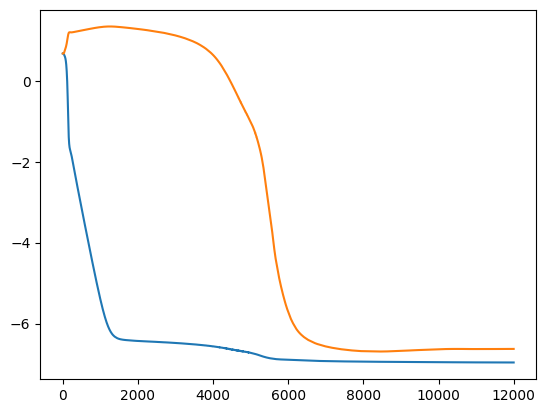

In [13]:
set_seed(seed)
model = Transformer(num_layers=num_layers, d_vocab=d_vocab, d_model=d_model, d_mlp=d_mlp, d_head=d_head, num_heads=num_heads, n_ctx=n_ctx, act_type=act_type, use_cache=False, use_ln=use_ln)
model.to('cuda');

save_dict=torch.load(root/run_name/'final.pth')
model.load_state_dict(save_dict['model'])

plt.plot(np.log10(save_dict['train_losses'])); plt.plot(np.log10(save_dict['test_losses']))

In [14]:
#Load pre-grokking model
# save_dict_2=torch.load(root/run_name/'0.pth')
# model.load_state_dict(save_dict_2['model'])

In [15]:
# plt.plot(train_losses); plt.plot(test_losses)

Ok, how to quickly find frequencies?

In [16]:
all_data = torch.tensor([(i, j, p) for i in range(p) for j in range(p)]).to('cuda')
labels = torch.tensor([fn(i, j) for i, j, _ in all_data]).to('cuda')
cache = {}
model.remove_all_hooks()
model.cache_all(cache)
# Final position only
original_logits = model(all_data)[:, -1]
# Remove equals sign from output logits
original_logits = original_logits[:, :-1]
original_loss = cross_entropy_high_precision(original_logits, labels)
print(f"Original loss: {original_loss.item()}")

Original loss: 1.9989081667002285e-07


In [17]:
for k in cache.keys():
    print(k, cache[k].shape)

blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_k torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_q torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_v torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_attn_pre torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_attn torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 4, 3, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [18]:
#Ok let's try pre -> the og. 
mr = einops.rearrange(cache['blocks.0.mlp.hook_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy() 
mr.shape

np.save(str(root/run_name)+'/mlp_hook_pre', mr)

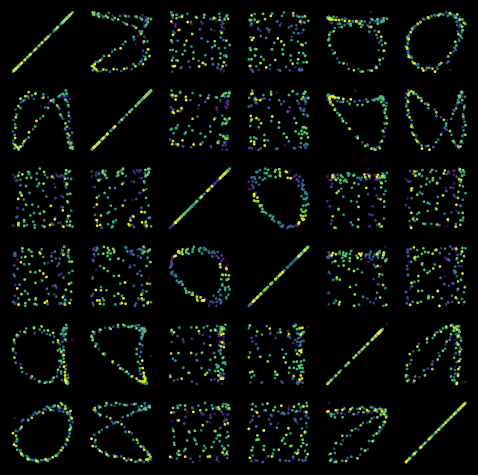

In [19]:
sample=[0, 3, 4, 5, 8, 10]
fig=plt.figure(0, (12,12), facecolor='k')
for i in range(len(sample)):
    for j in range(len(sample)):
        fig.add_subplot(12,12,12*i+j+1)
        plt.scatter(mr[:, 0, 2, sample[i]], mr[:, 0, 2, sample[j]], c=range(113), s=1)
        plt.axis('off')

One dimension at a time? 

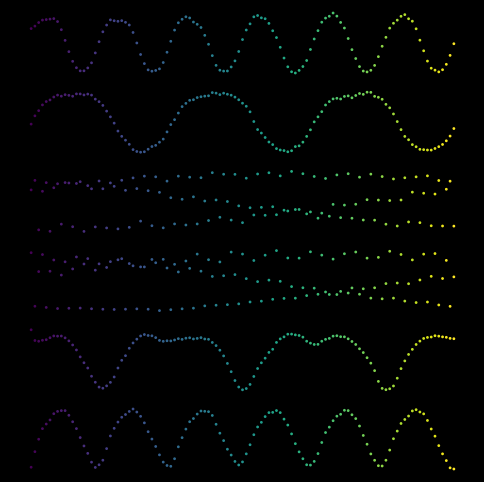

In [20]:
sample=[0, 3, 4, 5, 8, 10]
fig=plt.figure(0, (6,6), facecolor='k')
for i in range(len(sample)):
    fig.add_subplot(6,1,i+1)
    plt.scatter(np.arange(113), mr[:, 0, 2, sample[i]], c=range(113), s=1)
    plt.axis('off')

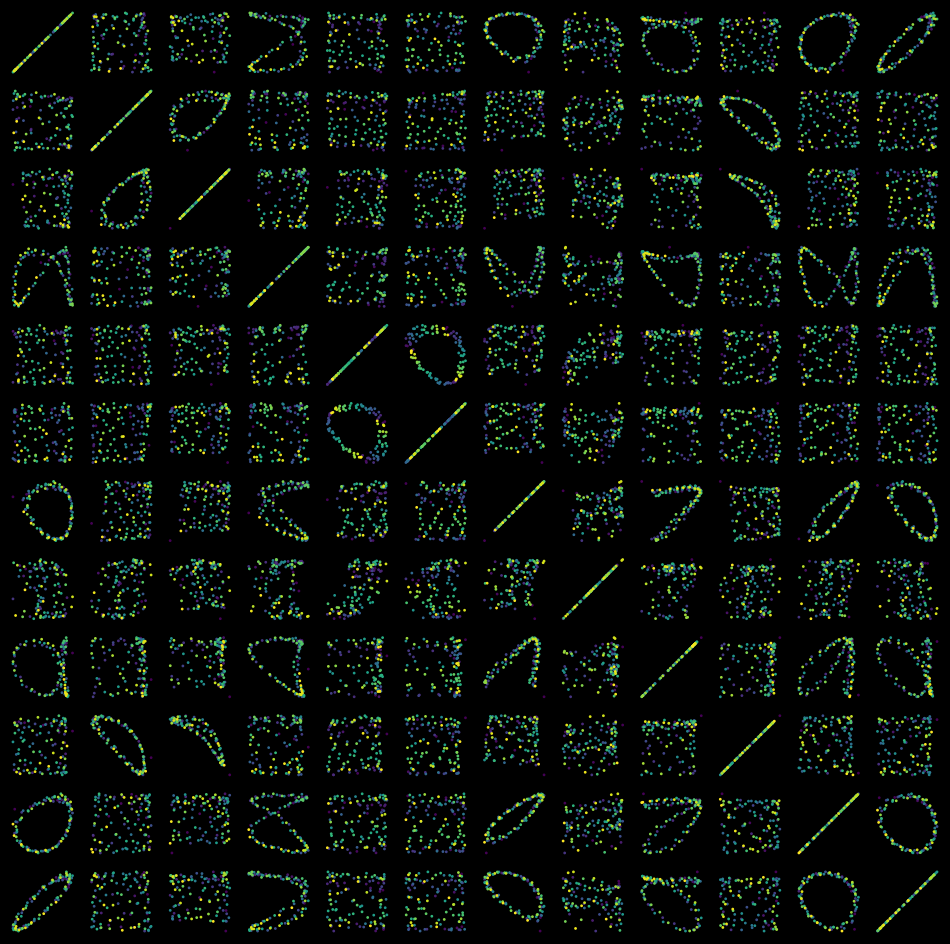

In [21]:
fig=plt.figure(0, (12,12), facecolor='k')
for i in range(12):
    for j in range(12):
        fig.add_subplot(12,12,12*i+j+1)
        plt.scatter(mr[:, 0, 2, i], mr[:, 0, 2, j], c=range(113), s=1)
        plt.axis('off')

## Search for Nice Example Neurons
- Looking for two neurons with strong cross terms, low frequencies, and bout pi/2 out of phase!

In [22]:
from tqdm import tqdm

In [23]:
# ---- Helper for classifying term type ----
def classify_term_type(kx, ky, is_dc):
    if is_dc:
        return "dc"
    if kx != 0 and ky == 0:
        return "row"
    if kx == 0 and ky != 0:
        return "col"
    if kx == 0 and ky == 0:
        return "dc"
    return "cross"  # kx != 0 and ky != 0


# ---- Loop over neurons and build DataFrame ----
all_rows = []

for neuron_idx in tqdm(range(512)):
    # 113 x 113 slice for this neuron
    m_slice = mr[:, :, 2, neuron_idx]

    components, Nx, Ny = compute_frequency_components(m_slice)
    terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)

    # Max amplitude (non-DC) for this neuron, for "strong" comparison later
    non_dc_terms = [t for t in terms if not t.get("is_dc", False)]
    max_amp = max((t["amplitude"] for t in non_dc_terms), default=0.0)

    for rank, t in enumerate(terms):
        is_dc = t.get("is_dc", False)
        kx = t["kx"]
        ky = t["ky"]
        amp = t["amplitude"]
        phase = t["phase"]

        term_type = classify_term_type(kx, ky, is_dc)

        all_rows.append({
            "neuron_idx": neuron_idx,
            "term_rank": rank,          # 0 = DC if include_dc=True
            "is_dc": is_dc,
            "term_type": term_type,     # "dc", "row", "col", "cross"
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase,
            "max_amp_neuron": max_amp,  # per neuron
        })

df = pd.DataFrame(all_rows)
df['relative_amplitude']=df['amplitude']/df['max_amp_neuron']

100%|████████████████████████████| 512/512 [00:16<00:00, 31.77it/s]


In [24]:
df['kx'].value_counts()

kx
0     1247
6      422
38     268
3      198
11     185
22     181
37      41
12      18
Name: count, dtype: int64

In [25]:
dff=df[df['kx']==6]
dff=dff[dff['ky']==6]

In [26]:
dff.sort_values(by='relative_amplitude', ascending=False)[:15]

,neuron_idx,term_rank,is_dc,term_type,kx,ky,amplitude,phase,max_amp_neuron,relative_amplitude
1716,343,1,False,cross,6,6,0.177941,1.046007,0.177941,1.000000
2266,453,1,False,cross,6,6,0.090294,-0.615084,0.090294,1.000000
581,116,1,False,cross,6,6,0.145402,-1.321902,0.145402,1.000000
2491,498,1,False,cross,6,6,0.127178,-1.894019,0.127178,1.000000
1551,310,1,False,cross,6,6,0.154692,1.088974,0.154692,1.000000
511,102,1,False,cross,6,6,0.136315,-0.524833,0.136315,1.000000
1661,332,1,False,cross,6,6,0.088458,-0.565918,0.088458,1.000000
2376,475,1,False,cross,6,6,0.235304,-1.947987,0.235304,1.000000
1806,361,1,False,cross,6,6,0.087610,-0.518084,0.087610,1.000000
282,56,2,False,cross,6,6,0.145135,-0.076828,0.145139,0.999972


In [27]:
neuron_idx=343
FT = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.575
    val += 0.178 * np.cos(2*np.pi*((6*i)/113) + 1.046) * np.cos(2*np.pi*((6*j)/113) + 1.046)
    val += 0.088 * np.cos(2*np.pi*((12*i)/113) + -2.111)
    val += 0.088 * np.cos(2*np.pi*((12*j)/113) + -2.111)
    val += 0.084 * np.cos(2*np.pi*((6*i)/113) + -0.0) * np.cos(2*np.pi*((107*j)/113) + -0.0)
    return val


In [28]:
def approx_M(i, j):
    val = 0.575
    val += 0.178 * np.cos(2*np.pi*((6*i)/113) + 1.046) * np.cos(2*np.pi*((6*j)/113) + 1.046)
    val += 0.088 * np.cos(2*np.pi*((12*i)/113) + -2.111)
    val += 0.088 * np.cos(2*np.pi*((12*j)/113) + -2.111)
    val += 0.084 * np.cos(2*np.pi*((6*i)/113) + -0.0) * np.cos(2*np.pi*((107*j)/113) + -0.0)
    return val

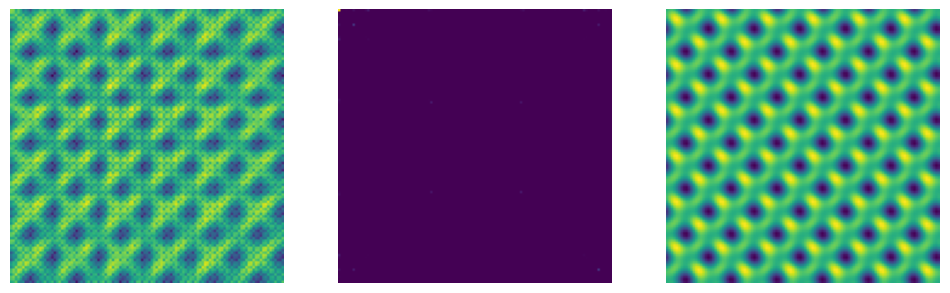

In [29]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(FT));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(m_approx); plt.axis('off');

In [30]:
plt.clf()
plt.figure(frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)
plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
plt.savefig(str(root/run_name)+'/activations_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

<Figure size 640x480 with 0 Axes>

In [31]:
neuron_idx=453	
FT = np.fft.fft2(mr[:,:,2,neuron_idx])

components, Nx, Ny = compute_frequency_components(mr[:,:,2,neuron_idx])
terms = components_to_terms(components, Nx, Ny, num_freqs=4, include_dc=True)
code_str = generate_python_reconstructor(terms, Nx, Ny,
                                         func_name="approx_M",
                                         decimals=3)
print(code_str)

def approx_M(i, j):
    val = 0.467
    val += 0.09 * np.cos(2*np.pi*((6*i)/113) + -0.615) * np.cos(2*np.pi*((6*j)/113) + -0.615)
    val += 0.075 * np.cos(2*np.pi*((6*i)/113) + -0.0) * np.cos(2*np.pi*((107*j)/113) + -0.0)
    val += 0.071 * np.cos(2*np.pi*((38*i)/113) + -0.399) * np.cos(2*np.pi*((38*j)/113) + -0.399)
    val += 0.059 * np.cos(2*np.pi*((6*j)/113) + -3.045)
    return val


In [32]:
def approx_M(i, j):
    val = 0.467
    val += 0.09 * np.cos(2*np.pi*((6*i)/113) + -0.615) * np.cos(2*np.pi*((6*j)/113) + -0.615)
    val += 0.075 * np.cos(2*np.pi*((6*i)/113) + -0.0) * np.cos(2*np.pi*((107*j)/113) + -0.0)
    val += 0.071 * np.cos(2*np.pi*((38*i)/113) + -0.399) * np.cos(2*np.pi*((38*j)/113) + -0.399)
    val += 0.059 * np.cos(2*np.pi*((6*j)/113) + -3.045)
    return val

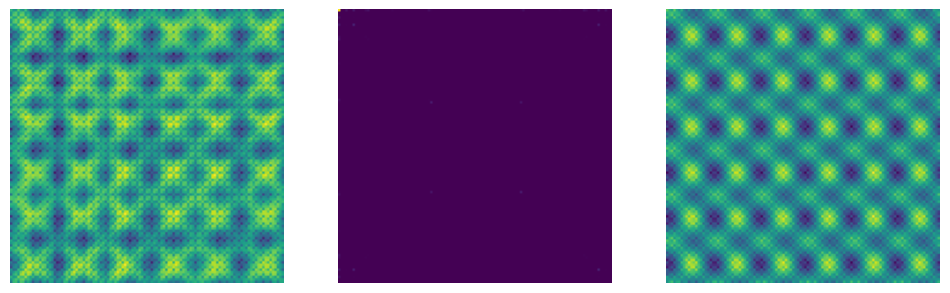

In [33]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=approx_M(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,3,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,3,2); plt.imshow(np.abs(FT));  plt.axis('off')
fig.add_subplot(1,3,3); plt.imshow(m_approx); plt.axis('off');

Ok sweet - I feel like that might work?

In [34]:
root/run_name

PosixPath('/home/stephen/grokking/grok_1764101670')

In [35]:
plt.clf()
plt.figure(frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)
plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
plt.savefig(str(root/run_name)+'/activations_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

<Figure size 640x480 with 0 Axes>

- Ok will need ot decouple training and viz at some point
- For now though, let's keep rollin.

### Fancy Trig Action

In [36]:
m_diff=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_diff[i,j]=np.cos(2*np.pi*((6*i)/113) + 1.046) * np.cos(2*np.pi*((6*j)/113) + 1.046) - \
                    np.cos(2*np.pi*((6*i)/113) + -0.615) * np.cos(2*np.pi*((6*j)/113) + -0.615)

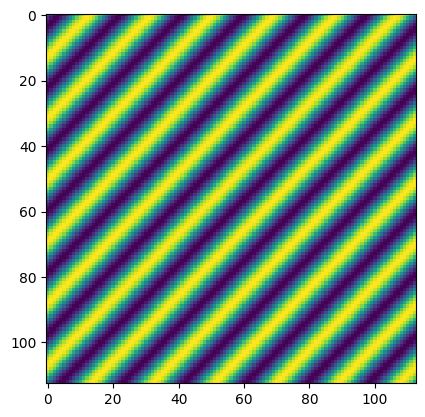

In [37]:
plt.imshow(m_diff)

- Nice, man I think that's going to be a really cool part of the animation!

In [38]:
#Somewhat different tooling for this section - could get me into a pickle
def fourier_approx_2d(x, num_freqs):
    """
    x: 2D real array, shape (Nx, Ny)
    num_freqs: number of Fourier coefficients to keep (by magnitude)

    Returns:
        F_sparse: sparse 2D Fourier spectrum (complex, same shape as x)
        x_hat: real reconstruction from the sparse spectrum
    """
    # 2D FFT
    F = np.fft.fft2(x)
    
    # Flatten and sort coefficients by magnitude (descending)
    flat = F.ravel()
    idx_sorted = np.argsort(np.abs(flat))[::-1]
    
    # Indices of top num_freqs coefficients
    keep_idx = idx_sorted[:num_freqs]
    
    # Build sparse spectrum
    flat_sparse = np.zeros_like(flat, dtype=complex)
    flat_sparse[keep_idx] = flat[keep_idx]
    F_sparse = flat_sparse.reshape(F.shape)
    
    # Reconstruct (take real part to remove tiny numerical imaginary noise)
    x_hat = np.fft.ifft2(F_sparse).real
    
    return F_sparse, x_hat

def spectrum_to_terms(F_sparse):
    """
    Turn a sparse spectrum into a list of (kx, ky, amplitude, phase) terms.
    Only nonzero entries are returned.
    """
    Nx, Ny = F_sparse.shape
    terms = []
    
    for (kx, ky), c in np.ndenumerate(F_sparse):
        if c == 0:
            continue
        amp = np.abs(c) / (Nx * Ny)   # matches np.fft normalization
        phase = np.angle(c)
        terms.append({
            "kx": kx,
            "ky": ky,
            "amplitude": amp,
            "phase": phase
        })
    
    return terms

def generate_python_reconstructor(terms, Nx, Ny, func_name="recon_func", decimals=4):
    """
    Generate a Python function as a string that reconstructs the signal
    using explicit cosine terms from a sparse Fourier representation.
    """

    lines = []
    # lines.append("import numpy as np\n")
    lines.append(f"def {func_name}(i, j):")
    
    if len(terms) == 0:
        lines.append("    return 0.0")
        return "\n".join(lines)

    lines.append("    return (")

    for t in terms:
        kx, ky = t["kx"], t["ky"]
        A = round(t["amplitude"], decimals)
        phi = round(t["phase"], decimals)

        if A == 0:
            continue

        # One cosine term
        line = (
            f"        {A} * np.cos(2*np.pi*((({kx}*i)/{Nx}) + "
            f"(({ky}*j)/{Ny})) + {phi}) +"
        )
        lines.append(line)

    # Remove trailing '+'
    lines[-1] = lines[-1].rstrip(" +")

    lines.append("    )")

    return "\n".join(lines)

# def reconstruction_error(x, x_hat, remove_mean=True):
#     if remove_mean:
#         x=x-x.mean(); x_hat=x_hat-x_hat.mean()
#     diff = x - x_hat
#     mse = np.mean(diff**2)
#     rel_l2 = np.linalg.norm(diff) / np.linalg.norm(x)
#     return mse, rel_l2

In [39]:
mr = einops.rearrange(cache['blocks.0.hook_mlp_out'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()
mr.shape

(113, 113, 3, 128)

In [40]:
np.save(str(root/run_name)+'/hook_mlp_out', mr)

In [41]:
neuron_idx=0
F_sparse, x_hat = fourier_approx_2d(mr[:,:,2,neuron_idx], num_freqs=6)

terms=spectrum_to_terms(F_sparse)
c=generate_python_reconstructor(terms, 113, 113)
print(c)

def recon_func(i, j):
    return (
        0.8749 * np.cos(2*np.pi*(((3*i)/113) + ((3*j)/113)) + -1.9893) +
        1.7677 * np.cos(2*np.pi*(((6*i)/113) + ((6*j)/113)) + 3.0373) +
        1.0432 * np.cos(2*np.pi*(((38*i)/113) + ((38*j)/113)) + -2.7589) +
        1.0432 * np.cos(2*np.pi*(((75*i)/113) + ((75*j)/113)) + 2.7589) +
        1.7677 * np.cos(2*np.pi*(((107*i)/113) + ((107*j)/113)) + -3.0373) +
        0.8749 * np.cos(2*np.pi*(((110*i)/113) + ((110*j)/113)) + 1.9893)
    )


In [42]:
def recon_func(i, j):
    return (
        # 0.8749 * np.cos(2*np.pi*(((3*i)/113) + ((3*j)/113)) + -1.9893) +
        1.7677 * np.cos(2*np.pi*(((6*i)/113) + ((6*j)/113)) + 3.0373) #+
        # 1.0432 * np.cos(2*np.pi*(((38*i)/113) + ((38*j)/113)) + -2.7589) +
        # 1.0432 * np.cos(2*np.pi*(((75*i)/113) + ((75*j)/113)) + 2.7589) +
        # 1.7677 * np.cos(2*np.pi*(((107*i)/113) + ((107*j)/113)) + -3.0373) +
        # 0.8749 * np.cos(2*np.pi*(((110*i)/113) + ((110*j)/113)) + 1.9893)
    )

In [43]:
plt.clf()
plt.figure(frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)
plt.imshow(np.rot90(mr[:,:,2,neuron_idx].T)) #have to transpose if transposing u and v and param_surface_1
plt.savefig(str(root/run_name)+'/activations_post_'+str(neuron_idx).zfill(3)+'.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

<Figure size 640x480 with 0 Axes>

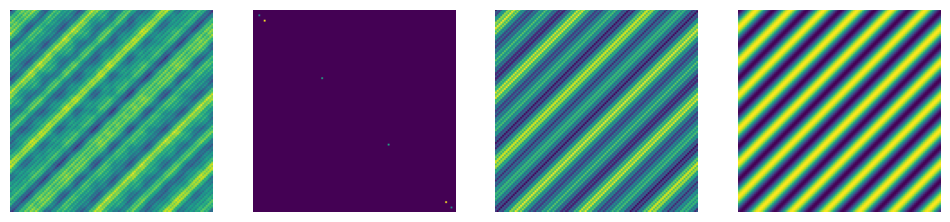

In [44]:
m_approx=np.zeros((p,p))
for i in range(p):
    for j in range(p):
        m_approx[i,j]=recon_func(i,j)

fig=plt.figure(0, (12, 6))
fig.add_subplot(1,4,1); plt.imshow(mr[:,:,2,neuron_idx]); plt.axis('off')
fig.add_subplot(1,4,2); plt.imshow(np.abs(F_sparse));  plt.axis('off')
fig.add_subplot(1,4,3); plt.imshow(x_hat); plt.axis('off');
fig.add_subplot(1,4,4); plt.imshow(m_approx); plt.axis('off');

In [45]:
# Helper variables
W_O = einops.rearrange(model.blocks[0].attn.W_O, 'm (i h)->i m h', i=num_heads)
W_K = model.blocks[0].attn.W_K
W_Q = model.blocks[0].attn.W_Q
W_V = model.blocks[0].attn.W_V
W_in = model.blocks[0].mlp.W_in
W_out = model.blocks[0].mlp.W_out
W_pos = model.pos_embed.W_pos.T
# We remove the equals sign dimension from the Embed and Unembed, so we can 
# apply a Fourier Transform over R^p
W_E = model.embed.W_E[:, :-1]
W_U = model.unembed.W_U[:, :-1].T

# The initial value of the residual stream at position 2 - constant for all inputs
final_pos_resid_initial = model.embed.W_E[:, -1] + W_pos[:, 2]
print('W_O', W_O.shape)
print('W_K', W_K.shape)
print('W_Q', W_Q.shape)
print('W_V', W_V.shape)
print('W_in', W_in.shape)
print('W_out', W_out.shape)
print('W_pos', W_pos.shape)
print('W_E', W_E.shape)
print('W_U', W_U.shape)
print('Initial residual stream value at final pos:', final_pos_resid_initial.shape)

W_O torch.Size([4, 128, 32])
W_K torch.Size([4, 32, 128])
W_Q torch.Size([4, 32, 128])
W_V torch.Size([4, 32, 128])
W_in torch.Size([512, 128])
W_out torch.Size([128, 512])
W_pos torch.Size([128, 3])
W_E torch.Size([128, 113])
W_U torch.Size([113, 128])
Initial residual stream value at final pos: torch.Size([128])


In [46]:
#Functional Form
# W_logit = W_out @ W_U[:, :-1]

# W_OV = W_V @ W_O
# W_neur = W_E @ W_OV @ W_in

# W_QK = W_Q @ W_K.transpose(-1, -2)
# W_attn = final_pos_resid_initial @ W_QK @ W_E.T / (cfg.d_head**0.5)

In [47]:
model.embed.W_E.shape

torch.Size([128, 114])

In [48]:
for k in cache:
    print(k, cache[k].shape)

blocks.0.hook_resid_pre torch.Size([12769, 3, 128])
blocks.0.attn.hook_k torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_q torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_v torch.Size([12769, 4, 3, 32])
blocks.0.attn.hook_attn_pre torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_attn torch.Size([12769, 4, 3, 3])
blocks.0.attn.hook_z torch.Size([12769, 4, 3, 32])
blocks.0.hook_attn_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_mid torch.Size([12769, 3, 128])
blocks.0.mlp.hook_pre torch.Size([12769, 3, 512])
blocks.0.mlp.hook_post torch.Size([12769, 3, 512])
blocks.0.hook_mlp_out torch.Size([12769, 3, 128])
blocks.0.hook_resid_post torch.Size([12769, 3, 128])


In [49]:
original_logits.shape

torch.Size([12769, 113])

In [50]:
mr = einops.rearrange(original_logits, "(x y) ... -> x y ...", x=p).detach().cpu().numpy()
mr.shape

(113, 113, 113)

In [51]:
np.save(str(root/run_name)+'/logits', mr)

(-0.5, 112.5, 112.5, -0.5)

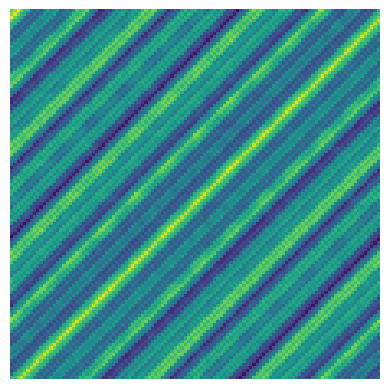

In [52]:
fig.add_subplot(1,4,1); plt.imshow(mr[:,:,2]); plt.axis('off')

Hmm does this actually need to get life flipped or something to make sense?

In [53]:
plt.clf()
plt.figure(frameon=False)
ax = plt.Axes(plt.gcf(), [0., 0., 1., 1.])
ax.set_axis_off()
plt.gcf().add_axes(ax)
plt.imshow(np.rot90(mr[:,:,2].T)) #have to transpose if transposing u and v and param_surface_1
plt.savefig(str(root/run_name)+'/logit_2.png', bbox_inches='tight', pad_inches=0, dpi=300)
plt.close()

<Figure size 640x480 with 0 Axes>

(-0.5, 112.5, 112.5, -0.5)

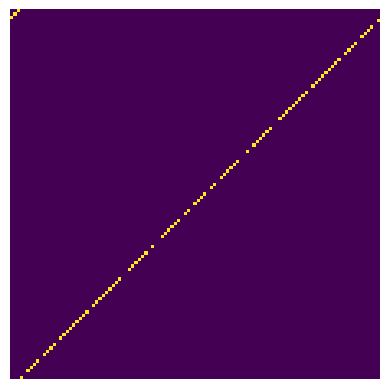

In [54]:
fig.add_subplot(1,4,1); plt.imshow(mr[:,:,2]>50); plt.axis('off')

Probls could be cool to see, we'll see!

In [55]:
probs=torch.nn.Softmax(1)(original_logits.detach().cpu())

In [56]:
probs.shape

torch.Size([12769, 113])

In [57]:
original_logits.shape

torch.Size([12769, 113])

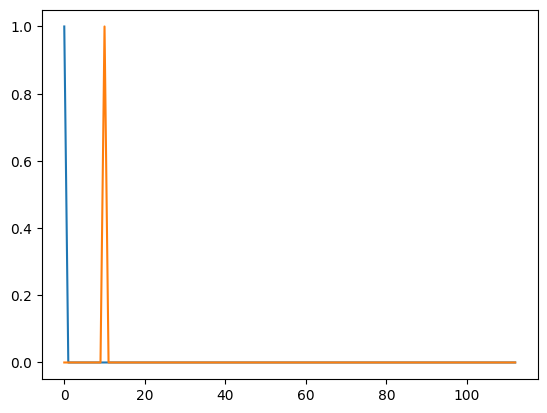

In [58]:
plt.plot(probs[0, :])
plt.plot(probs[10, :])

In [59]:
mr = einops.rearrange(probs, "(x y) ... -> x y ...", x=p).detach().cpu().numpy()
mr.shape

(113, 113, 113)

(-0.5, 112.5, 112.5, -0.5)

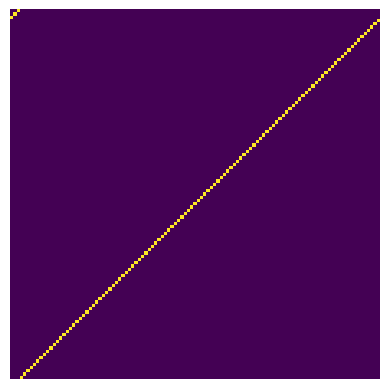

In [60]:
fig.add_subplot(1,4,1); plt.imshow(mr[:,:,2]); plt.axis('off')

### Ok let's try a linear probe to find sines/cosines 

In [61]:
cache['blocks.0.hook_resid_pre'].shape

torch.Size([12769, 3, 128])

In [62]:
mr = einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu().numpy()
mr.shape

(113, 113, 3, 128)

In [63]:
mr[:,0, 0, :].shape

(113, 128)

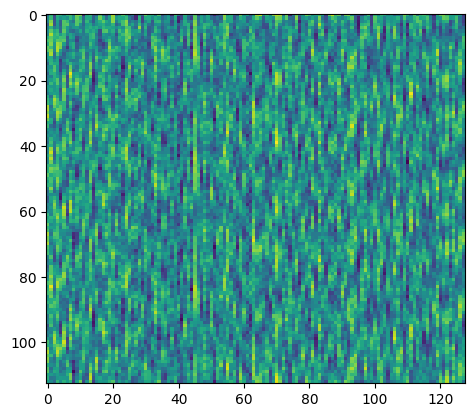

In [64]:
plt.imshow(mr[:,0, 0, :])

Linear probe let's go. 

In [65]:
def compute_probe(X, p, k):

    k = 6
    w = 2 * np.pi * k / p

    # x indexes the batch dimension
    x = torch.arange(p, dtype=torch.float32)
    
    # Targets: sin(wx), cos(wx)
    target_sin = torch.sin(w * x)
    target_cos = torch.cos(w * x)
    
    # Stack into shape [113, 2]
    Y = torch.stack([target_sin, target_cos], dim=1)       # [N, 2]
    
    # Add bias column if desired
    X_ = torch.cat([X, torch.ones(p, 1)], dim=1)           # [N, 129]
    
    # Solve the linear least-squares problem: W = (X^T X)^-1 X^T Y
    W, *_ = torch.linalg.lstsq(X_, Y)                      # W: [129, 2]
    
    # Extract weights
    probe_W = W[:-1]       # [128, 2]
    probe_b = W[-1]        # [2]
    
    pred = X @ probe_W + probe_b 

    return probe_W, probe_b, pred

In [66]:
X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[:,0, 0, :]

probe_W, probe_b, pred_1 = compute_probe(X, p, k=6)

In [67]:
X.shape

torch.Size([113, 128])

In [68]:
pred_1.shape

torch.Size([113, 2])

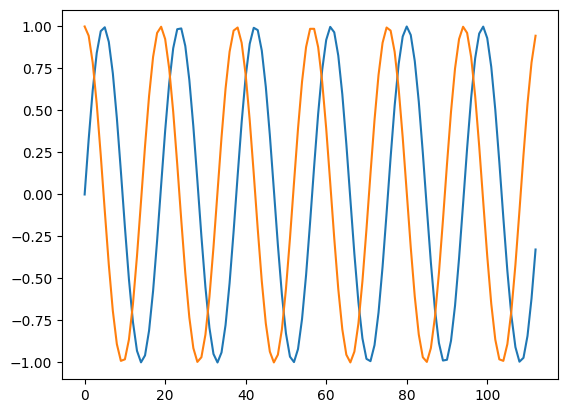

In [69]:
plt.plot(pred_1[:,0].numpy())
plt.plot(pred_1[:,1].numpy()) 

In [70]:
probe_W.shape, probe_b.shape, pred_1.shape

(torch.Size([128, 2]), torch.Size([2]), torch.Size([113, 2]))

In [71]:
np.save(str(root/run_name)+'/probe_1', pred_1.numpy())

- Ok I think this is prett legit.
- Will be really interesting to see the evolution of this sucker during training

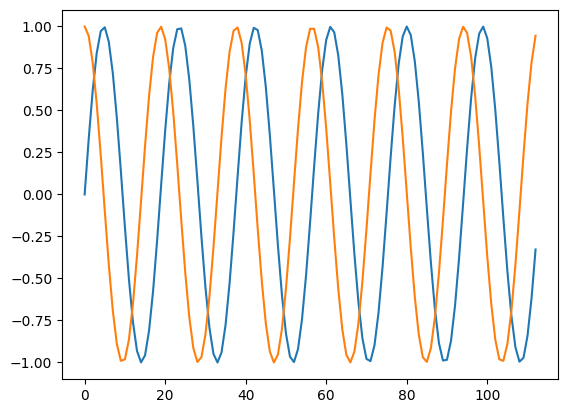

In [72]:
X=einops.rearrange(cache['blocks.0.hook_resid_pre'], "(x y) ... -> x y ...", x=p).detach().cpu()[0,:, 1, :]

probe_W, probe_b, pred_2 = compute_probe(X, p, k=6)

plt.plot(pred_2[:,0].numpy())
plt.plot(pred_2[:,1].numpy()) 

In [73]:
np.save(str(root/run_name)+'/probe_2', pred_2.numpy())

- This works like too well lol.
- Ok so I think we viz linear probe outputsin manim - watching them during training and grokking is going to be dope.
- Ok let's get the "to manim" pipeline going here -> kinda annoying but I'll be grateful for it later. 

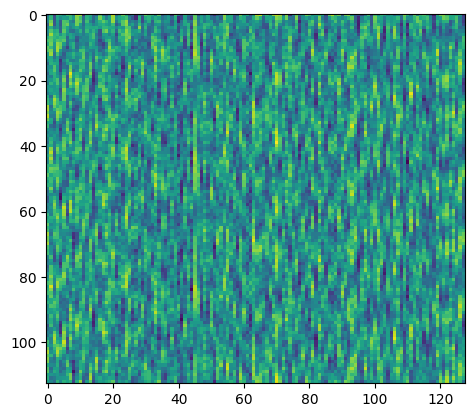

In [74]:
plt.imshow(mr[0,:, 1, :])

In [75]:
W_E.shape

torch.Size([128, 113])

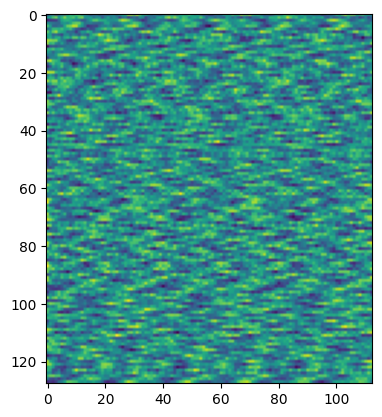

In [76]:
plt.imshow(W_E.detach().cpu().numpy())

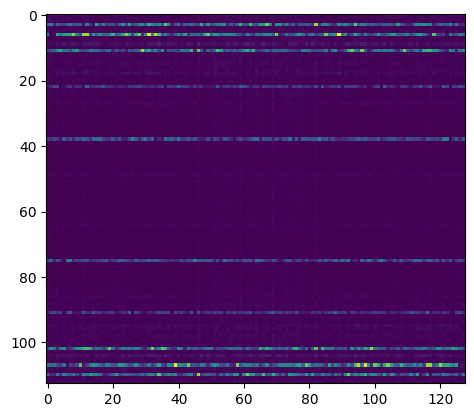

In [77]:
F=np.fft.fft2(W_E.detach().cpu().numpy().T)
plt.imshow(np.abs(F))

In [78]:
import math

def fit_frequency_from_rows(W_E: torch.Tensor, k: int, num_rows: int | None = None):
    """
    Approximate cos(w x) as a linear combination of rows of W_E.

    Args:
        W_E: tensor of shape (d_model, seq_len) = (128, 113)
        k:   integer frequency index; w = 2*pi*k/seq_len
        num_rows: if not None, restrict the solution to use only the
                  num_rows rows with largest |weight|.

    Returns:
        A dict with:
            'indices': indices of rows used (shape [m])
            'coeffs':  coefficients for those rows (shape [m])
            'approx':  length-seq_len approximation vector
            'target':  length-seq_len target cos(w x) vector
    """
    d_model, seq_len = W_E.shape

    # x = column index, 0..seq_len-1
    x = torch.arange(seq_len, device=W_E.device, dtype=W_E.dtype)
    w = 2 * math.pi * k / seq_len
    target = torch.cos(w * x)  # shape (seq_len,)

    # We want sum_i c_i * W_E[i, :] ≈ target.
    # Writing c as a vector of length d_model:
    #   W_E^T @ c ≈ target
    # so we solve A c ≈ target with A = W_E^T (shape: seq_len x d_model)
    A = W_E.T  # (seq_len, d_model)

    # First solve unrestricted least squares
    # (minimize ||A c - target||_2)
    full_sol = torch.linalg.lstsq(A, target).solution  # (d_model,)

    if num_rows is not None and num_rows < d_model:
        # Pick the num_rows rows with biggest |coefficient|
        top_idx = torch.topk(full_sol.abs(), num_rows).indices  # (num_rows,)

        # Re-solve least squares restricted to these rows for a cleaner fit
        A_sub = A[:, top_idx]  # (seq_len, num_rows)
        sub_sol = torch.linalg.lstsq(A_sub, target).solution  # (num_rows,)

        approx = A_sub @ sub_sol  # (seq_len,)
        return {
            "indices": top_idx,   # which rows of W_E to use
            "coeffs": sub_sol,    # weights for sum/difference of those rows
            "approx": approx,
            "target": target,
        }
    else:
        approx = A @ full_sol
        return {
            "indices": torch.arange(d_model, device=W_E.device),
            "coeffs": full_sol,
            "approx": approx,
            "target": target,
        }

In [79]:
result = fit_frequency_from_rows(W_E, k=6, num_rows=50)

In [80]:
result

{'indices': tensor([ 19,  75,  82,   7,  69,  55,  71,   4, 125, 122,  17,  30,  61,   2,
          79,   1, 109,  56,  16,  36,  39, 112,  46, 107,  43,  90,  65,  49,
          59,  97, 104,  83,  15,  32,  18,  42, 110,   6,  76,  99,  10,  57,
          45, 120,  81,  54,  47,  94,  58,  73], device='cuda:0'),
 'coeffs': tensor([-8.2928,  3.2759, -9.1026,  2.0460,  0.6954, -2.4058,  6.7759, -2.7371,
         -6.1663, -4.7750, -2.3131,  2.6290, -2.0116,  1.1008,  6.0064, -5.6046,
          2.4784,  4.9153,  1.4133, -0.8394, -1.6542, -3.0902,  9.6234,  1.7108,
          4.4724, -0.4925, -3.1678, -0.2561, -0.2337, -0.1267,  8.7071,  2.9161,
         -0.5718, -7.4485, -4.5828, -0.6995,  1.7120,  1.3706, 10.5270, -4.8619,
          0.8812,  6.2470,  5.4633,  2.5409,  3.9293,  0.5645, -2.9557,  6.5557,
          2.2476, -1.1661], device='cuda:0', grad_fn=<LinalgLstsqBackward0>),
 'approx': tensor([ 1.0235,  0.9213,  0.7790,  0.5316,  0.2071, -0.0925, -0.4004, -0.6966,
         -0.9014, -

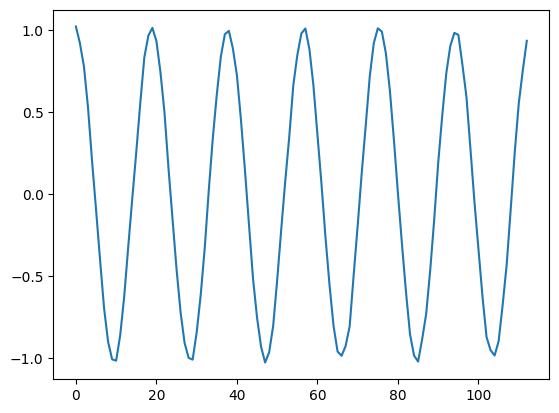

In [81]:
plt.plot(result['approx'].detach().cpu().numpy())